In [51]:
import pandas as pd

def get_human_dataset():
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('dataset1/human_activity/features.txt', sep='\s+',
                                  header=None, names=['column_index', 'column_name'])
    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스크 객체로 다시 반환
    feature_name = feature_name_df.iloc[:,1].values.tolist()
    
    # 학습 피처 데이터 세트와 테스트 피처 데이터를 DataFrame으로 로딩, 칼럼명은 feature_name 적용
    # 우선 칼럼명 없이 데이터프레임으로 불러온 후 칼럼명을 추가함
    X_train = pd.read_csv('dataset1/human_activity/train/X_train.txt', sep='\s+', header=None)
    X_train.columns = feature_name
    X_test = pd.read_csv('dataset1/human_activity/test/X_test.txt', sep='\s+',header=None)
    X_test.columns = feature_name
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv('dataset1/human_activity/train/y_train.txt', sep='\s+', header=None, names = ['action'])
    y_test = pd.read_csv('dataset1/human_activity/test/y_test.txt', sep='\s+', header=None, names = ['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = get_human_dataset()

In [52]:
# 로지스틱 리그레션 정확도 평가
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
accuracy = accuracy_score(y_test,lr_pred)
print('lr 정확도:{0:.4f}'.format(accuracy))

lr 정확도:0.9579


###  앙상블 학습

* 정형 데이터의 예측 분석 영역에서는 매우 높은 예측 성능. Voting, Bagging 과 Boosting
* 배깅 방식의 대표인 Random Forest는 뛰어난 예측 성능, 상대적으로 빠른 수행시간, 유연성 등으로 애용.
* 부스팅의 효시는 Gradient Boosting, 한 단계 발전시키면서도 시간 단축시킨 XgBoost, LightGBM이 정형 데이터의 분류 영역에서 
  활용도 확대
* 앙상블의 앙상블이라고 불리는 스태킹 기법
* 앙상블의 기본 알고리즘은 결정 트리

In [53]:
# 랜덤포레스트 정확도 평가
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('rf 정확도:{0:.4f}'.format(accuracy))

rf 정확도:0.9253


In [54]:
# 다중 클래스 분류 평가
from sklearn.metrics import classification_report
confusion = confusion_matrix(y_test, pred)
print('혼동행렬')
print(confusion,'\n')

y_test = pd.read_csv('dataset1/human_activity/test/y_test.txt', sep='\s+', header=None, names = ['action'])

y_test = y_test.action.values
print(y_test[:10])
print(pred[:10])
print(classification_report(y_test,pred))

혼동행렬
[[486   4   6   0   0   0]
 [ 38 426   7   0   0   0]
 [ 22  44 354   0   0   0]
 [  0   0   0 440  51   0]
 [  0   0   0  48 484   0]
 [  0   0   0   0   0 537]] 

[5 5 5 5 5 5 5 5 5 5]
[5 5 5 5 5 5 5 5 5 5]
              precision    recall  f1-score   support

           1       0.89      0.98      0.93       496
           2       0.90      0.90      0.90       471
           3       0.96      0.84      0.90       420
           4       0.90      0.90      0.90       491
           5       0.90      0.91      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.92      2947
weighted avg       0.93      0.93      0.93      2947



In [55]:
# 교차검증 및 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV
params = {'n_estimators':[100],
         'max_depth':[6,8,10,12],
         'min_samples_leaf':[8],
         'min_samples_split':[8]}
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2,n_jobs=-1)
grid_cv.fit(X_train,y_train)

print('최적 하이퍼 파라미터:{}, 최고 예측 정확도:{:.4f}'.format(grid_cv.best_params_,grid_cv.best_score_))

최적 하이퍼 파라미터:{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}, 최고 예측 정확도:0.9180


In [56]:
best_gr_clf = grid_cv.best_estimator_
pred1 = best_gr_clf.predict(X_test)

print(classification_report(y_test,pred1))

              precision    recall  f1-score   support

           1       0.87      0.97      0.92       496
           2       0.90      0.90      0.90       471
           3       0.95      0.82      0.88       420
           4       0.91      0.89      0.90       491
           5       0.90      0.92      0.91       532
           6       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



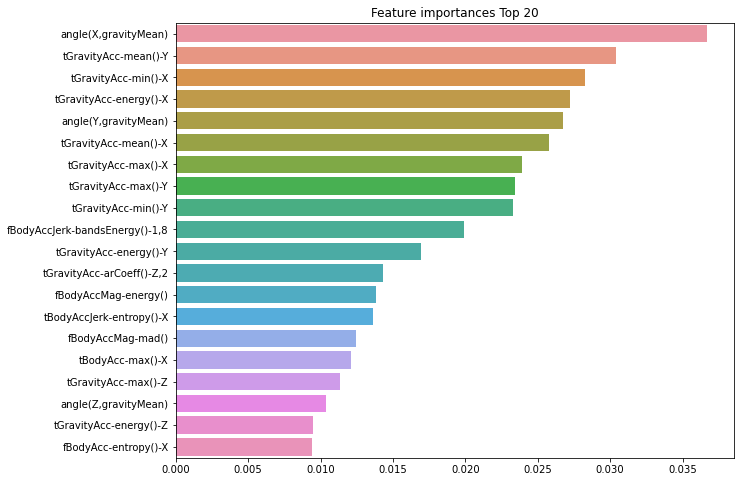

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

ftr_importances_values = best_gr_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(10,8))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()
plt.close()

### Voting Classifier

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

In [2]:
import warnings
warnings.filterwarnings('ignore')
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)
# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)],voting='soft')

X_train, X_test,y_train,y_test = train_test_split(cancer.data, cancer.target,test_size=0.2,random_state=156)
vo_clf.fit(X_train,y_train)
pred = vo_clf.predict(X_test)
print('Voting 정확도:{0:.4f}'.format(accuracy_score(y_test,pred)))

classifiers = [lr_clf,knn_clf]
for classifier in classifiers:
    classifier.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    class_name=classifier.__class__.__name__
    print('{0} 정확도:{1:.4f}'.format(class_name, accuracy_score(y_test,pred)))

Voting 정확도:0.9474
LogisticRegression 정확도:0.9386
KNeighborsClassifier 정확도:0.9386
